In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete1UYP2H/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete1UYP2H/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
dataset['train']

<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [5]:
def preprocessImages(input_image, input_mask):
  input_image = input_image / 255.0
  input_mask -= 1
  return input_image, input_mask

In [6]:
def loadImages(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  input_image, input_mask = preprocessImages(input_image, input_mask)
  return input_image, input_mask

In [7]:
info.splits['train'].num_examples

3680

In [8]:
train_length = info.splits['train'].num_examples
batch_size = 64

In [9]:
train_images = dataset['train'].map(loadImages, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(loadImages, num_parallel_calls=tf.data.AUTOTUNE)

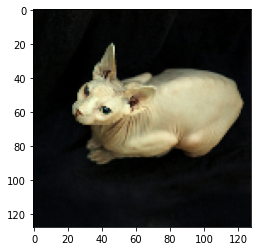

In [10]:
img, mask = train_images.take(2)
img = img[0]
mask = mask[0]
plt.imshow(tf.keras.utils.array_to_img(img))

In [11]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=10):
    super().__init__()
    self.augmented_input = tf.keras.layers.RandomFlip(mode='horizontal', seed=seed)
    self.augmented_lables = tf.keras.layers.RandomFlip(mode='horizontal', seed=seed)

  def call(self, inputs, labels):
    inputs = self.augmented_input(inputs)
    labels = self.augmented_lables(labels)
    return inputs, labels

In [12]:
def plotImages(images):
  plt.figure(figsize=(10,10))
  for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(tf.keras.utils.array_to_img(images[i]))
    plt.axis('off')
  plt.show()

In [13]:
# images, masks = train_images.take(2)
# img, mask = images[0], masks[0]
# plt.imshow(tf.keras.utils.array_to_img(img))

In [14]:
train_batches = (train_images).cache().shuffle(1000).batch(batch_size).repeat().map(Augment()).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
test_batches = test_images.batch(batch_size)

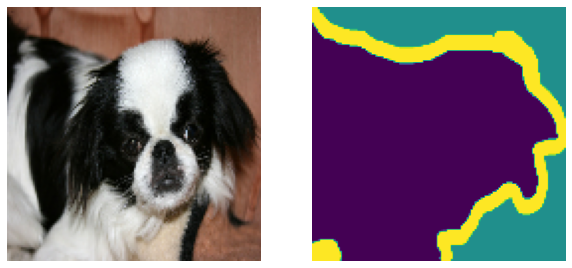

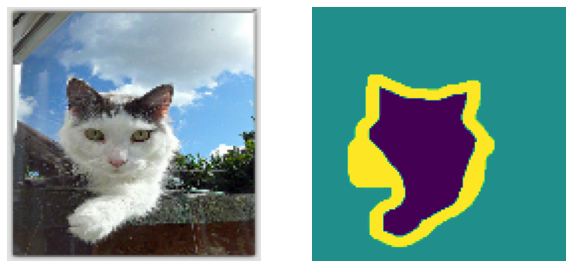

In [16]:
for images, masks in train_batches.take(2):
  img, mask = images[0], masks[0]
  imagesList = [img, mask]
  plotImages(imagesList)

In [17]:
from tensorflow.keras.applications import MobileNetV2

In [18]:
base_model = MobileNetV2(include_top=False, input_shape=(128,128,3))

9420800/9406464 [==============================] - 0s 0us/step


In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [20]:
layer_names = [
               'block_1_expand_relu',
               'block_3_expand_relu',
               'block_6_expand_relu',
               'block_13_expand_relu',
               'block_16_project',

]

In [21]:
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

In [22]:
# down_stack
new_model = tf.keras.Model(inputs=base_model.input, outputs = base_model_outputs)

In [23]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-8xyn0y33
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-8xyn0y33
  Created wheel for tensorflow-examples: filename=tensorflow_examples-a09319553fd73de7152ed11e3ed56c72f35a91af_-py3-none-any.whl size=299301 sha256=110f17c814136ed59edb5da4faf2ce1b3120309941d56763a76bd1f9bce742f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-8up3lkok/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

In [24]:
from tensorflow_examples.models.pix2pix import pix2pix

In [25]:
up_stack = [
            pix2pix.upsample(512, 3),
            pix2pix.upsample(256, 3),
            pix2pix.upsample(128, 3),
            pix2pix.upsample(64, 3),
]

In [26]:
def unet_model(output_channel):
  inputs = tf.keras.layers.Input(shape=[128,128,3])
  down_sample = new_model(inputs)
  x = down_sample[-1]
  skips = reversed(down_sample[:-1])

  for up, c in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, c])
  
  last = tf.keras.layers.Conv2DTranspose(filters=output_channel,
                                         kernel_size=3, strides=2,
                                         padding='same')
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [27]:
model = unet_model(3)

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_2[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

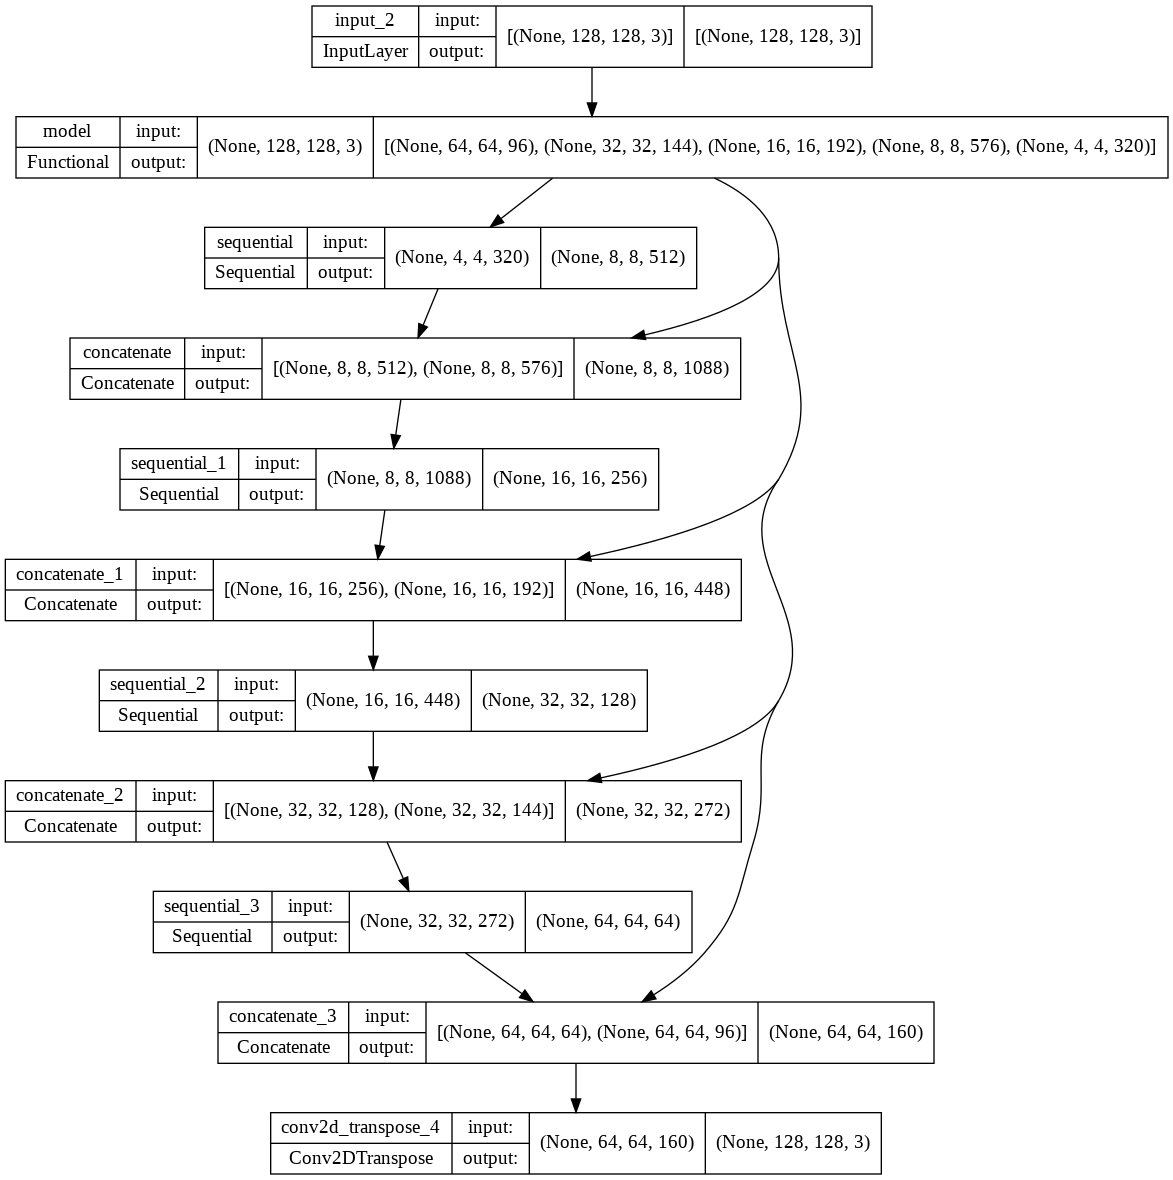

In [30]:
tf.keras.utils.plot_model(model,  show_shapes=True)

In [31]:
def createMask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [32]:
def showPred(dataset=None, num=1):
  if(dataset):
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      img, mask = image[0], mask[0]
      imagesList = [img, mask, createMask(pred_mask)]
      plotImages(imagesList)

  else:
    img, mask = images[0], masks[0]
    pred_mask = model.predict(img[tf.newaxis, ...])
    imagesList = [img, mask, createMask(pred_mask)]
    plotImages(imagesList)

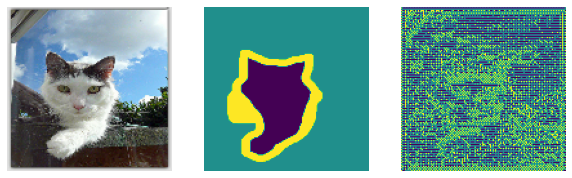

In [33]:
showPred()

In [36]:
class ShowCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    showPred()

Epoch 1/5
 6/57 [==>...........................] - ETA: 12s - loss: 0.1922 - accuracy: 0.9171WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1082s vs `on_train_batch_end` time: 0.1346s). Check your callbacks.


58/57 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.9177

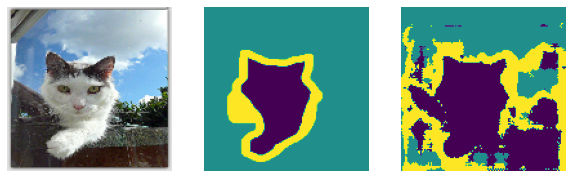

57/57 [==============================] - 13s 230ms/step - loss: 0.1891 - accuracy: 0.9177
Epoch 2/5
58/57 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9193

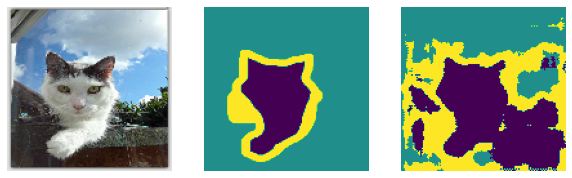

57/57 [==============================] - 13s 228ms/step - loss: 0.1838 - accuracy: 0.9193
Epoch 3/5
58/57 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9209

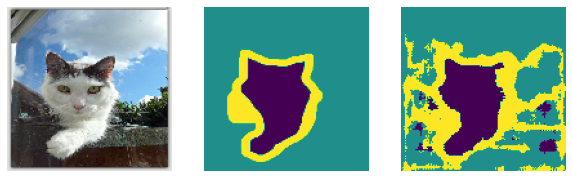

57/57 [==============================] - 13s 229ms/step - loss: 0.1791 - accuracy: 0.9209
Epoch 4/5
58/57 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.9209

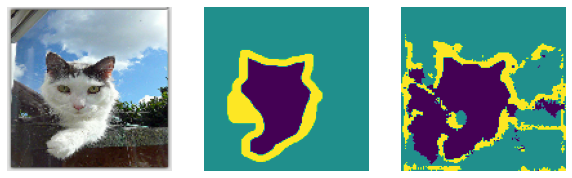

57/57 [==============================] - 13s 232ms/step - loss: 0.1792 - accuracy: 0.9209
Epoch 5/5
58/57 [==============================] - ETA: 0s - loss: 0.1803 - accuracy: 0.9205

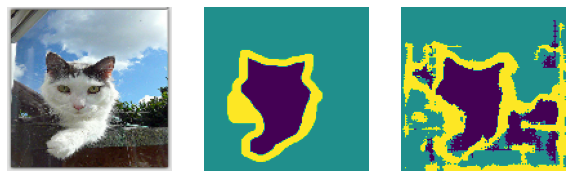

57/57 [==============================] - 13s 234ms/step - loss: 0.1803 - accuracy: 0.9205


In [37]:
steps_per_epoch = train_length / batch_size
model.fit(train_batches, epochs=5, steps_per_epoch=steps_per_epoch, callbacks=[ShowCallback()])